# Predict the selling price of a property using Numpy + Pandas in Jupyter

## Regression

Regression is a fundamental machine learning algorithm used for modeling the relationship between a dependent variable (target) and one or more independent variables (features).

Le'ts build a regression machine learning model and use it to predict the selling price of a property using sales data from Connecticut.

We-ll use scikit-learn’s RandomForestRegressor to train the model and evaluate it on a test set
The overall objective is to predict the sale amount of property using **5 feature variables and 1 target variable:** 

#### **Feature Variables** ####

1.  **List Year:** The year the property was listed
2.  **Town:** The Town in which the property is
3.  **Assessed Value:** Reported assessed value
4.  **Sales Ratio:** The ratio of the sale value to the assessed value
5.  **Property Type:** The type of property

#### **Target Variable** ####
1.  **Sale Amount:** The reported sale amount.

## Scikit-learn

Scikit-learn is a machine learning library for the Python programming language. It features various classification, regression and clustering learning algorithms. 

## Dependencies

- pandas - To work with solid data-structures, n-dimensional matrices and perform exploratory data analysis.
- matplotlib - To visualize data using 2D plots.
- scikit-learn - To create machine learning models easily and make predictions.
- numpy - To work with arrays.

# Install dependencies, obtain & load data

In [ ]:
%pip install -U pandas matplotlib numpy scikit-learn

In [195]:
import pandas as pd
import seaborn as sns 

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [196]:
# Read in the data with read_csv() into a Pandas Dataframe
data_path = '~/Downloads/Real_Estate_Sales_2001-2020_GL.csv'
sales_df = pd.read_csv(data_path)

# Use .info() to show the features (i.e. columns) in the dataset along with a count and datatype
sales_df.info()

/var/folders/21/_103sf7x3zgg4yk3syyg448h0000gn/T/ipykernel_60538/748677588.py:3: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv(data_path)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997211 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997162 non-null  object 
 5   Assessed Value    997213 non-null  float64
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     614767 non-null  object 
 9   Residential Type  608904 non-null  object 
 10  Non Use Code      289681 non-null  object 
 11  Assessor Remarks  149864 non-null  object 
 12  OPM remarks       9934 non-null    object 
 13  Location          197697 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 106.5+ MB


## Data wrangling
The raw data has more data points than we're interested in and the data has some missing values.

We need to clean up the data to a form the model can understand

In [197]:
# Get the counts of the null values in each column
sales_df.isnull().sum()

Serial Number            0
List Year                0
Date Recorded            2
Town                     0
Address                 51
Assessed Value           0
Sale Amount              0
Sales Ratio              0
Property Type       382446
Residential Type    388309
Non Use Code        707532
Assessor Remarks    847349
OPM remarks         987279
Location            799516
dtype: int64

We're going to begin by dropping all the columns we don't need for this problem. 
This includes: ['Serial Number','Date Recorded', 'Address', 'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location']
Moreover, a lot of these fields have null values. 
We'll keep 'Property Type' but we'll drop all null values and later on we'll see how to handle such data

In [198]:
# drop the unnecessary columns
columns_to_drop = ['Serial Number','Date Recorded', 'Address', 'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location']

sales_df = sales_df.drop(columns=columns_to_drop)
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   List Year       997213 non-null  int64  
 1   Town            997213 non-null  object 
 2   Assessed Value  997213 non-null  float64
 3   Sale Amount     997213 non-null  float64
 4   Sales Ratio     997213 non-null  float64
 5   Property Type   614767 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 45.6+ MB


In [199]:
# remove all rows with null Property Type
sales_df = sales_df.dropna(subset=['Property Type'])
sales_df.isnull().sum()

List Year         0
Town              0
Assessed Value    0
Sale Amount       0
Sales Ratio       0
Property Type     0
dtype: int64

Great! now all rows and all colums have data. lets see the shape of the data

In [201]:
# print shape of dataframe
sales_df.shape

(614767, 6)

In [202]:
# as a python convention, lets rename the column names to be in snake_case
sales_df = sales_df.rename(columns=lambda x: x.lower().replace(' ', '_'))
sales_df.columns

Index(['list_year', 'town', 'assessed_value', 'sale_amount', 'sales_ratio',
       'property_type'],
      dtype='object')

## Visualizations

### Histograms

<Axes: >

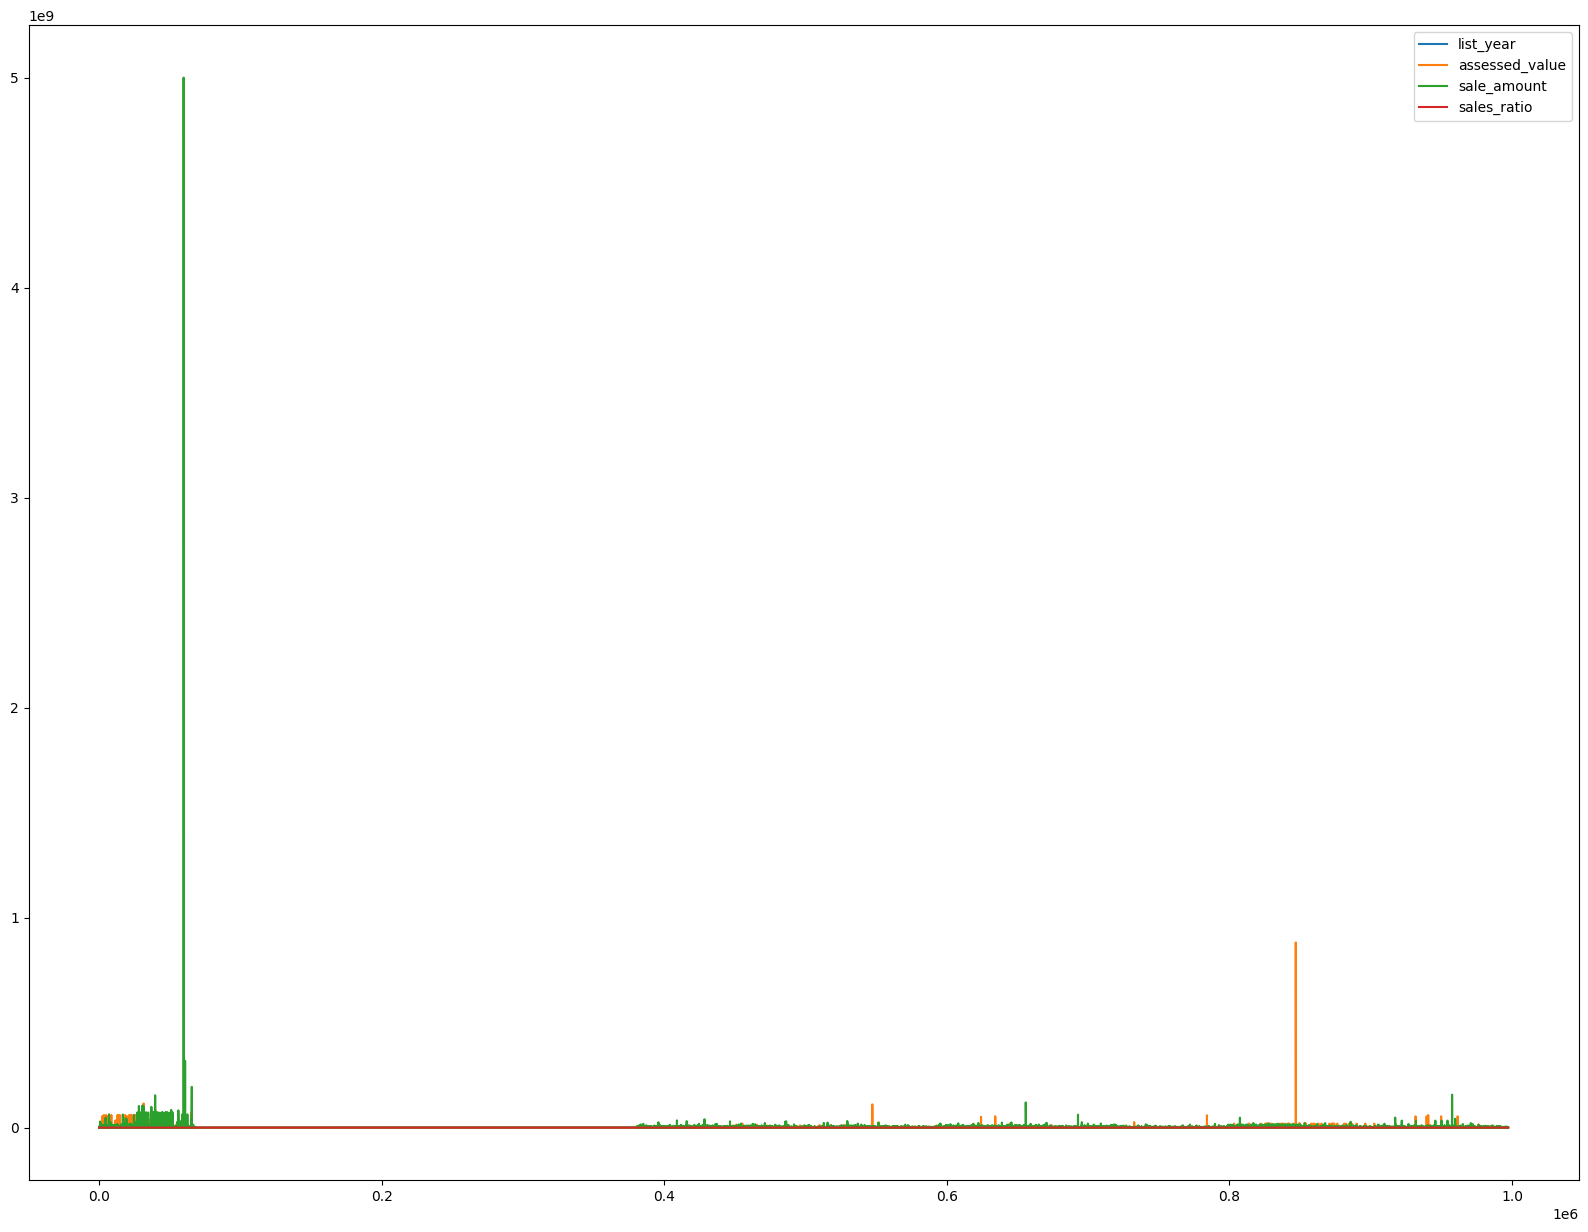

In [204]:
# let's do histograms for the all the features to understand the data distributions
# from the graph we can clearly see there are outliers in the data
# this can skew the accuracy of the model
sales_df.plot(figsize=(20,15))


### Clean data to remove outliers
We can set a few conditions on the data in order to remove outliers 
- Filter sale amount and assessed value to values less than 100M
- Filter sale amount to be greater than 2000

We'll then compare the performance of two models trained using the cleaned and the raw data with outliers

(614767, 6)


<Axes: >

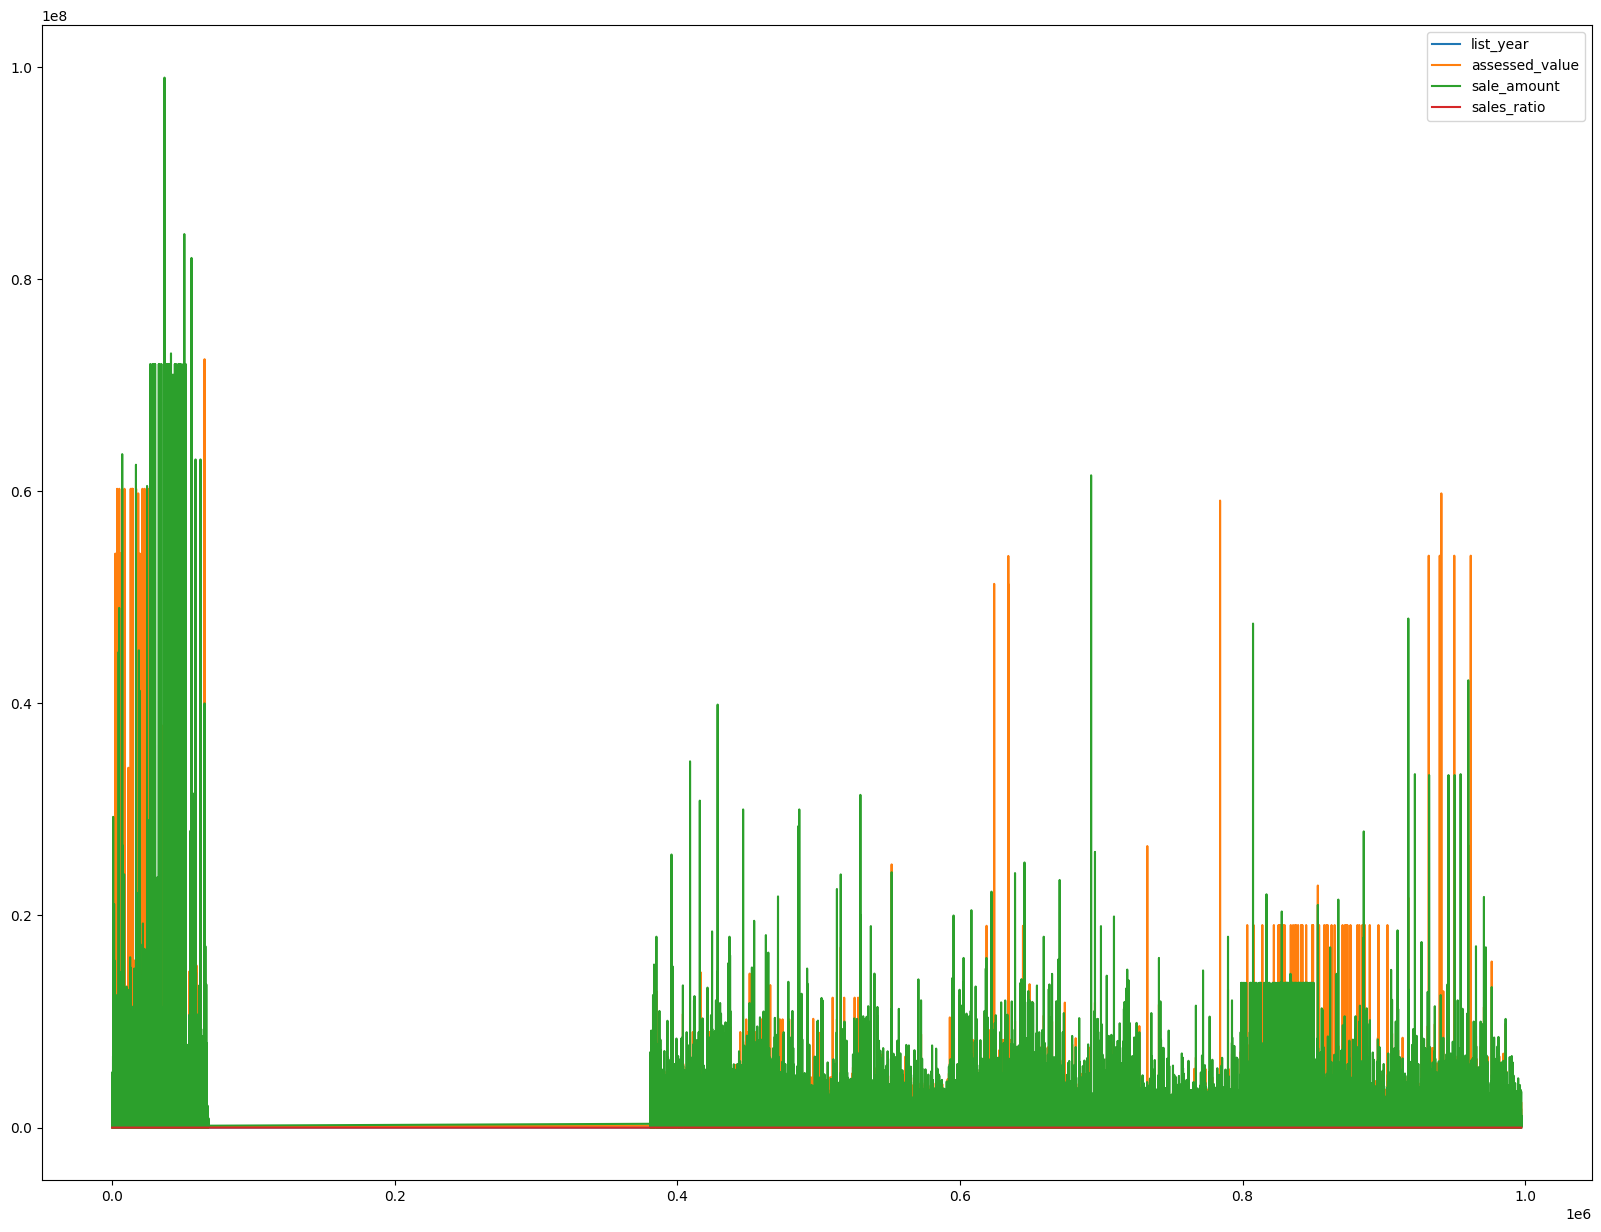

In [231]:
sales_df_clean = sales_df[(sales_df['sale_amount'] < 1e8) & (sales_df['assessed_value'] < 1e8) & (sales_df['sale_amount'] > 2000)]

# plot the data again to see the difference
sales_df_clean.plot(figsize=(20,15))

#### Use a heatmap to show correlation

Correlation shows us how much the feature variables are correlated to each other. This can help in filtering out the columns that are too similar and therefore have the same information. We want very low correlation between columns.

In [206]:
# Plot a graphical correlation matrix for each pair of columns in the dataframe
sales_df_tmp = sales_df.copy()
# drop Town and Property Type columns to get the correlation matrix
sales_df_tmp = sales_df_tmp.drop(columns=['town', 'property_type'])
corr = sales_df_tmp.corr() # data frame correlation function
print(corr)

                list_year  assessed_value  sale_amount  sales_ratio
list_year        1.000000        0.005172     0.004900    -0.003554
assessed_value   0.005172        1.000000     0.041633     0.001610
sale_amount      0.004900        0.041633     1.000000    -0.000161
sales_ratio     -0.003554        0.001610    -0.000161     1.000000


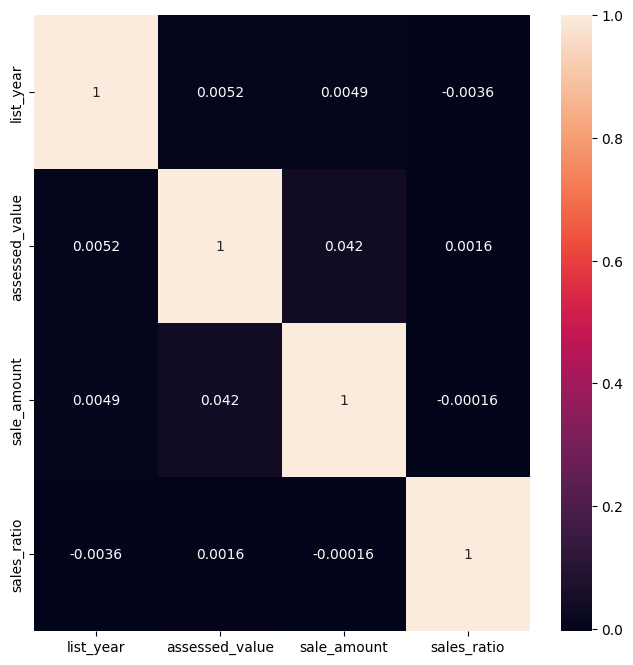

In [207]:
# make the heatmap larger in size
plt.figure(figsize = (8,8))

sns.heatmap(corr, annot=True)
plt.show()

## Encode categorical data

We nead to encode the categorical data (town and property type) into numerical data using one-hot encoding

In [208]:

sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614767 entries, 0 to 997211
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   list_year       614767 non-null  int64  
 1   town            614767 non-null  object 
 2   assessed_value  614767 non-null  float64
 3   sale_amount     614767 non-null  float64
 4   sales_ratio     614767 non-null  float64
 5   property_type   614767 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 32.8+ MB


In [209]:
# let's count the number of unique categories for town and property type
sales_df["property_type"].value_counts()

property_type
Single Family     401612
Condo             105420
Residential        60728
Two Family         26408
Three Family       12586
Vacant Land         3163
Four Family         2150
Commercial          1981
Apartments           486
Industrial           228
Public Utility         5
Name: count, dtype: int64

In [210]:
# town
sales_df["town"].value_counts()

town
Bridgeport       18264
Waterbury        17938
Stamford         17374
Norwalk          14637
Greenwich        12329
                 ...  
Eastford           266
Scotland           258
Canaan             250
Union              121
***Unknown***        1
Name: count, Length: 170, dtype: int64

### One-Hot Encoding
One-hot encoding is a technique used in machine learning and data preprocessing to convert categorical data into a binary format that can be fed into machine learning algorithms. Each category or label in a categorical variable is represented as a binary vector, where only one element in the vector is "hot" (set to 1) to indicate the category, while all others are "cold" (set to 0). This allows machine learning algorithms to work with categorical data, which typically requires numerical inputs. One-hot encoding is essential when working with categorical variables in tasks like classification and regression, as it ensures that the model can interpret and make predictions based on these variables.

In [211]:
# Let's see how the Panda's get_dummies() function works
print(pd.get_dummies(sales_df['town']))

        ***Unknown***  Andover  Ansonia  Ashford   Avon  Barkhamsted  \
0               False    False     True    False  False        False   
1               False    False    False     True  False        False   
2               False    False    False    False   True        False   
3               False    False    False    False   True        False   
4               False    False    False    False   True        False   
...               ...      ...      ...      ...    ...          ...   
997207          False    False    False    False  False        False   
997208          False    False    False    False  False        False   
997209          False    False    False    False  False        False   
997210          False    False    False    False  False        False   
997211          False    False    False    False  False        False   

        Beacon Falls  Berlin  Bethany  Bethel  ...  Willington  Wilton  \
0              False   False    False   False  ...       Fals

In [212]:
# let's replace the town and property columns using pandas' get_dummies()
sales_df_encoded = pd.get_dummies(data=sales_df, columns=['property_type', 'town'])
sales_df_clean_encoded = pd.get_dummies(data=sales_df_clean, columns=['property_type', 'town'])

# print the first few observations; notice the old OCEAN_PROXIMITY column is gone
sales_df_encoded.head()

,list_year,assessed_value,sale_amount,sales_ratio,property_type_Apartments,property_type_Commercial,property_type_Condo,property_type_Four Family,property_type_Industrial,property_type_Public Utility,...,town_Willington,town_Wilton,town_Winchester,town_Windham,town_Windsor,town_Windsor Locks,town_Wolcott,town_Woodbridge,town_Woodbury,town_Woodstock
0,2020,150500.0,325000.0,0.4630,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2020,253000.0,430000.0,0.5883,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2020,130400.0,179900.0,0.7248,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2020,619290.0,890000.0,0.6958,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2020,862330.0,1447500.0,0.5957,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Train the models

In [213]:
import sklearn
from sklearn.model_selection import train_test_split

# Split target variable and feature variables
y = sales_df_encoded['sale_amount']
X = sales_df_encoded.drop(columns=['sale_amount'])
y_cleaned = sales_df_clean_encoded['sale_amount']
X_cleaned = sales_df_clean_encoded.drop(columns=['sale_amount'])

### Split training & test data
We need to split our data into training data and test data in an 80:20 or 70:30 ratio depending on the use case.

The reasoning is that we'll use the training data to train the model and the test data to validate it. The model needs to perform well with test data that it has never seen

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cleaned, y_cleaned, random_state=42, shuffle=True, test_size=0.2)

# print the shapes of the new X objects
print(X_train.shape)
print(X_train_c.shape)

(491813, 184)
(491595, 184)


###  RandomForestRegressor

In scikit-learn, the `RandomForestRegressor` is a machine learning model that is used for regression tasks. It is an ensemble learning method that combines the predictions of multiple decision trees to make more accurate and robust predictions. When creating a `RandomForestRegressor`, you can specify several parameters to configure its behavior. Here are some of the common parameters passed to the `RandomForestRegressor`:

1. **n_estimators**: The number of decision trees in the forest. Increasing the number of trees can improve the model's performance, but it also increases computation time.

2. **max_depth**: The maximum depth of each decision tree in the forest. It limits the tree's growth and helps prevent overfitting.

3. **random_state**: A random seed for reproducibility. If you set this value, you'll get the same results each time you run the model with the same data.

These are some of the commonly used parameters, but the `RandomForestRegressor` has many more options for fine-tuning your model. You can choose the appropriate values for these parameters based on your specific regression task and dataset.

Random Forest is a non-parametric model, meaning it does not make strong assumptions about the underlying data distribution. It is highly flexible and can capture complex relationships in the data.

#### Overfitting
This is the tendency of a model to be very sensitive to outliers. Such a model performs very well on training data but poorly on unseen data

#### Underfitting
Underfitting occurs when a model is too simple or lacks the capacity to capture the underlying patterns in the data. Such a model generalizes too much and results in inaccurate results.

In [215]:
from sklearn.ensemble import RandomForestRegressor

# Create a  regressor using all the feature variables
# we will tweak the parameters later to improve the performance of the model
rf_model = RandomForestRegressor(n_estimators=10,random_state=10)

rf_model_clean = RandomForestRegressor(n_estimators=10,random_state=10)
# Train the models using the training sets
rf_model.fit(X_train, y_train)
rf_model_clean.fit(X_train_c, y_train_c)

RandomForestRegressor(n_estimators=10, random_state=10)

## Run the predictions
After training the model, we use it to make predictions based on the unseen test data

In [216]:
#run the predictions on the training and testing data
y_rf_pred_test = rf_model.predict(X_test)
y_rf_clean_pred_test = rf_model_clean.predict(X_test_c)

In [217]:
#compare the actual values (ie, target) with the values predicted by the model
rf_pred_test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_rf_pred_test})

rf_pred_test_df

,Actual,Predicted
769037,47000.0,46960.0
615577,463040.0,462650.0
635236,137000.0,137246.0
901781,235000.0,235000.0
630118,305000.0,305250.0
...,...,...
679168,378000.0,377490.0
965471,179900.0,179780.0
459234,295000.0,295100.0
876950,13000.0,13117.6


In [218]:
#compare the actual values (ie, target) with the values predicted by the model
rf_pred_clean_test_df = pd.DataFrame({'Actual': y_test_c, 'Predicted': y_rf_clean_pred_test})

rf_pred_clean_test_df

,Actual,Predicted
915231,195000.0,194800.0
51414,198000.0,198540.0
520001,410000.0,409900.0
18080,230000.0,230500.0
456006,260000.0,260100.0
...,...,...
673908,160000.0,160000.0
767435,379900.0,380383.2
2850,2450000.0,2463313.0
954634,250000.0,250000.0


## Evaluate the models
Now let's compare what the model produced and the actual results
We'll use R^2 method to evaluate the model's performance. This method is primarily used to evaluate the performance of regressor models.

In [219]:
# Determine accuracy uisng 𝑅^2
from sklearn.metrics import r2_score

score = r2_score(y_test, y_rf_pred_test)
score_clean = r2_score(y_test_c, y_rf_clean_pred_test)

print("R^2 test Raw - {}%".format(round(score, 2) *100))
print("R^2 test Clean - {}%".format(round(score_clean, 2) *100))

R^2 test Raw - 78.0%
R^2 test Clean - 95.0%


From this we can see a clear difference in performance between the cleaned data and the raw data that includes the outliers. This is a basic way to solve the problem and in another tutorial we'll compare different methods of eliminating outliers to reduce overfitting.

## Feature Importance
Its important to findout which of the feature variables we passed was the most important in determining the target variable which is the sale amount in our case. Random Forest Regressor provides a method to determine this. Lets plot the 5 most important features

<Axes: title={'center': 'Feature Importance in Raw Data'}>

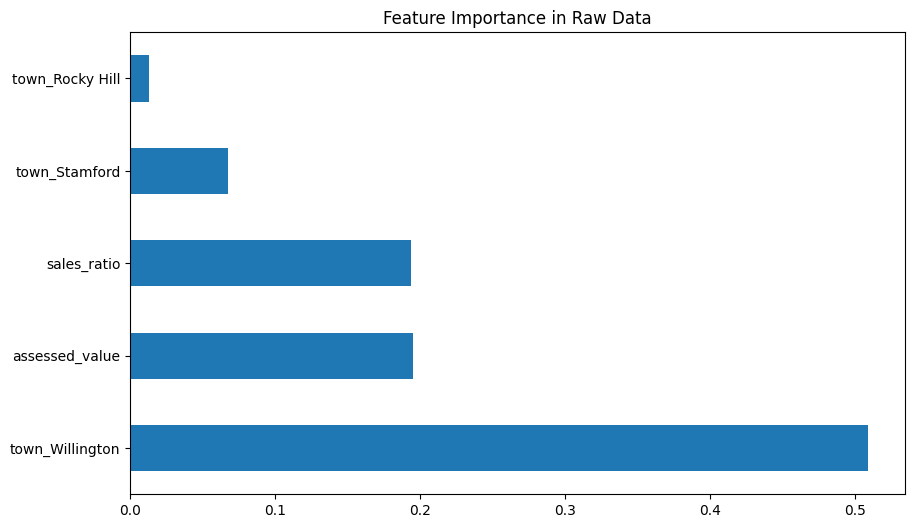

In [220]:

plt.figure(figsize=(10,6))
feat_importances = pd.Series(rf_model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(5).plot(kind='barh', title='Feature Importance in Raw Data')

<Axes: title={'center': 'Feature Importance in Clean Data'}>

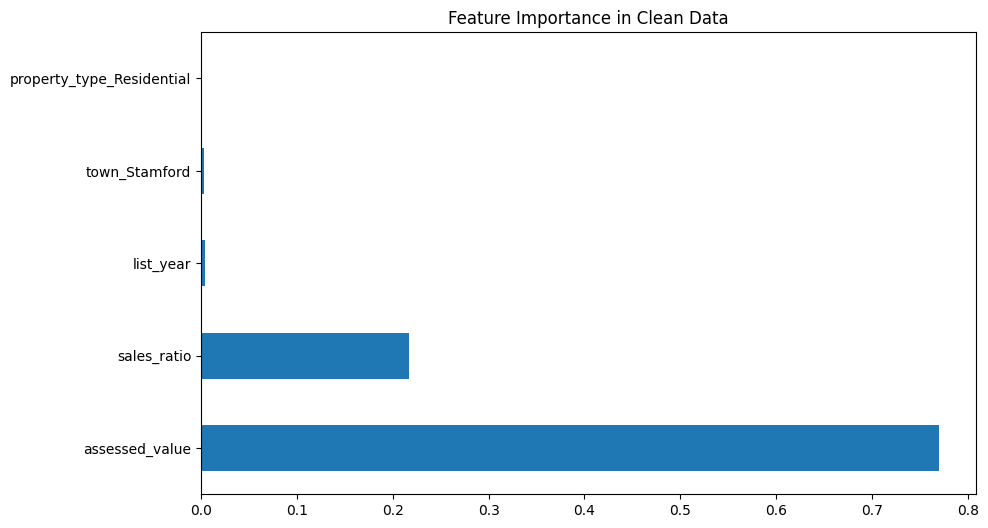

In [221]:

plt.figure(figsize=(10,6))
feat_importances = pd.Series(rf_model_clean.feature_importances_, index = X_train_c.columns)
feat_importances.nlargest(5).plot(kind='barh', title='Feature Importance in Clean Data')

Interestingly, according to the raw data, a property being in Willington town is a higher predictor of the score than the assessed value. This indicates that the data is being affected by outliers.

In the cleaned data, we can clearly see that the assessed value is the most important feature, which is what we would expect from the data. 

### Cross validation
Hyper parameters can be used to tweak the performance of the model. Cross validation can be used to evaluate the performance of the model with different hyperparameters. 

Consider the n_estimators parameter which represents the number of decision tress in the forest. Lets see whether increasing it can increase model performance

We'll use Kfold cross validation to see what effect changing the n_estimators has on the MSE (Mean Square Error)  and R^2 score of the model. This should help us determine the optimal value

Here's how KFold cross-validation works:

- **Splitting the Data**: The dataset is divided into k roughly equal-sized folds, where "k" is the number of desired folds specified as an argument.

- **Training and Validation**: The model is trained and validated k times, with each of the k folds serving as the validation set exactly once. The remaining k-1 folds collectively form the training set.

- **Metrics**: For each iteration (or "fold"), the model's performance is assessed using a chosen evaluation metric (e.g., mean squared error, accuracy, etc.).

- **Average and Variance**: After completing k iterations, the evaluation metric scores are typically averaged to obtain a single performance estimate for the model. This average score provides an estimate of the model's performance and generalization ability.

Key benefits of KFold cross-validation include:

- It provides a more reliable estimate of a model's performance by using multiple validation sets.
- It helps detect overfitting because the model is evaluated on different data subsets.
- It allows for a more thorough assessment of model performance, especially with limited data.

In [233]:
from sklearn.model_selection import KFold, cross_val_score
# Define a range of n_estimators values to test
n_estimators_values = [10, 20]

# Set up cross-validation (e.g., 5-fold cross-validation)
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = {'n_estimators': [], 'MSE': [], 'R-squared': []}

for n_estimators in n_estimators_values:
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    
    # Perform cross-validation and calculate MSE and R-squared
    mse_scores = -cross_val_score(model, X_cleaned, y_cleaned, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_cleaned, y_cleaned, cv=kf, scoring='r2')
    
    results['n_estimators'].append(n_estimators)
    results['MSE'].append(mse_scores.mean())
    results['R-squared'].append(r2_scores.mean())

results_df = pd.DataFrame(results)
print(results_df)


   n_estimators           MSE  R-squared
0            10  3.120811e+10   0.959579
1            20  2.970360e+10   0.961509


As you can see, there isn't much to gain by increasing the n_estimators but the runtime of the model increases significantly. 

So what if we use a different regressoion model other than Random Forest? say the extreme Gradient Boosting regressor. Is the more accuracy to gain? Stay tuned. 